In [1]:
import mpi4py # Message Passing Interface module for parallel computing
import dolfinx # The engine
import ufl # Unified Form Language library
from dolfinx.fem.petsc import LinearProblem # From PETSc library: Portable, Extensible Toolkit for Scientific Computation
import pyvista as pv # PyVista Library

## Torsion

Given a beam subjected to torsional loading, the entire physical formulation reduces to the torsion function $u(x, y)$ defined on the beam's section, which must satisfy the Laplace equation with Neumann boundary conditions:

\begin{equation*}
    \Delta u = 0 \quad \frac{\partial u}{\partial n} = y n_x - x n_y
\end{equation*}

Where $n$ is the outward unit vector of beam's section. Let's solve the problem using the FEM (Finite Element Method) approach on the unit square

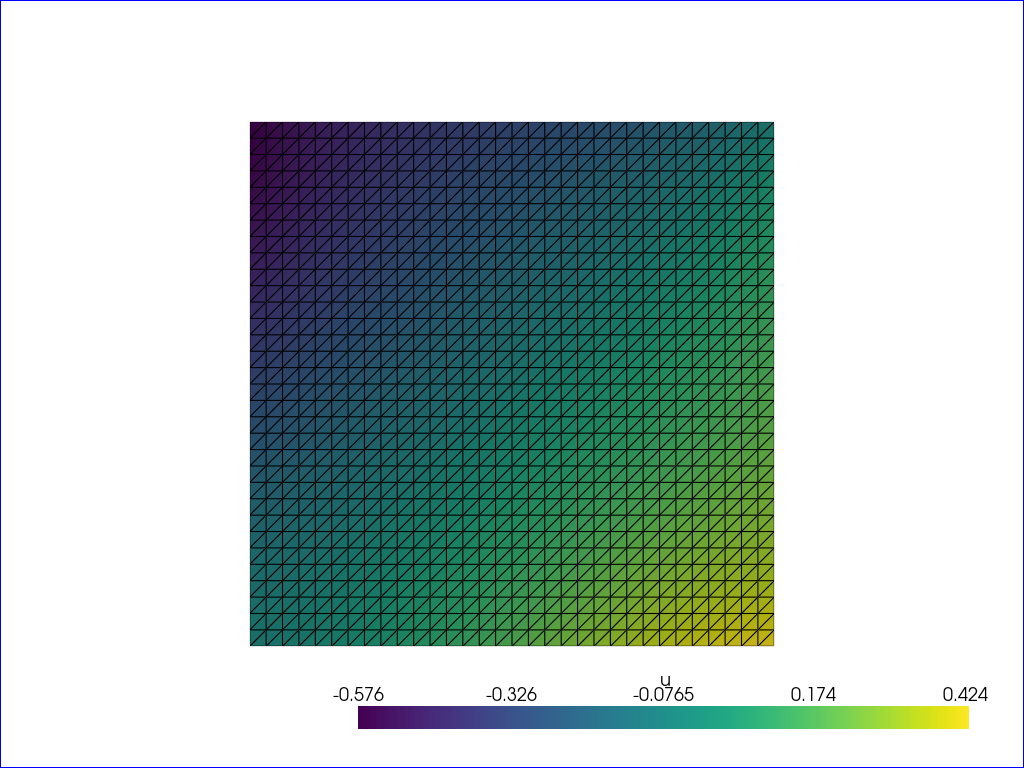

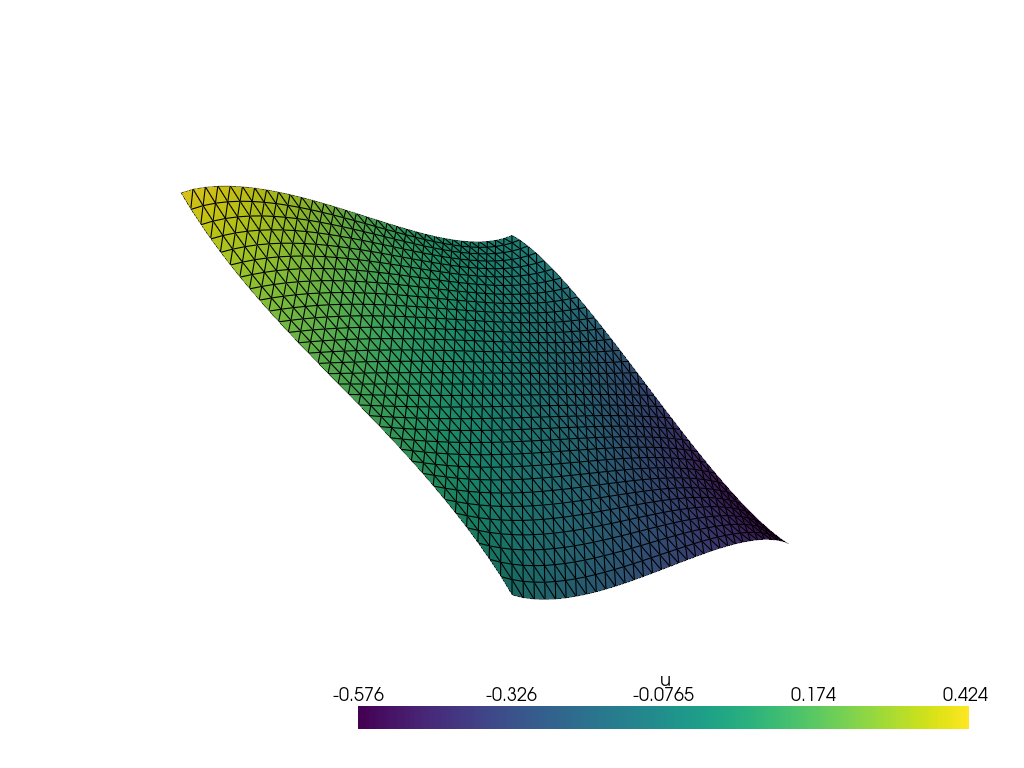

In [2]:
# Creating the mesh
domain = dolfinx.mesh.create_unit_square(comm = mpi4py.MPI.COMM_WORLD,
                                         nx = 16,
                                         ny = 16,
                                         cell_type = dolfinx.mesh.CellType.quadrilateral
                                         )

# Creating the discretized space function V whose elements are quadratic Lagrange polynomials
V = dolfinx.fem.functionspace(mesh = domain,
                              element = ("Lagrange", 2)
                              )

# Defining the normal unit vector and the variables x and y
n = ufl.FacetNormal(domain)
r = ufl.SpatialCoordinate(domain)

# Defining the trial and test functions
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

# Neumann condition
g = r[0] * n[1] - r[1] * n[0]

# Writing the variational problem
a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = - g * v * ufl.ds

# Solving the PDE
problem = LinearProblem(a,
                        L,
                        petsc_options = {"ksp_type": "preonly",
                                       "pc_type": "lu"})
uh = problem.solve()

# Plotting
u_topology, u_cell_types, u_geometry = dolfinx.plot.vtk_mesh(V)
u_grid = pv.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pv.Plotter(notebook = True,
                       border = True,
                       border_color = 'blue',
                       line_smoothing = True)
u_plotter.add_mesh(u_grid, show_edges = True)
u_plotter.view_xy()
u_plotter.show()

warped = u_grid.warp_by_scalar()
plotter2 = pv.Plotter()
plotter2.add_mesh(warped, show_edges = True, show_scalar_bar = True)
plotter2.show()

## Shear

For a beam subjected to shear loading, the entire physical formulation reduces to the shear function $u(x, y)$, which now satisfies a Poisson equation with Neumann boundary conditions as well:

\begin{equation*}
    \Delta u = - 2 y \quad \frac{\partial u}{\partial n} = \nu \left[ n_x n_y + \frac{1}{2} n_y \left(y ^ 2 - x ^ 2 \right) \right]
\end{equation*}

Moreover, another condition must be satisfied to ensure the existence of a solution:

\begin{equation*}
    \iint _ {A} 2 y \, dA = \oint _ {\partial A} - C \nu \left[ n_x n_y + \frac{1}{2} n_y \left(y ^ 2 - x ^ 2 \right) \right] \, ds
\end{equation*}

Where $C$ is a constant to hold the equality.

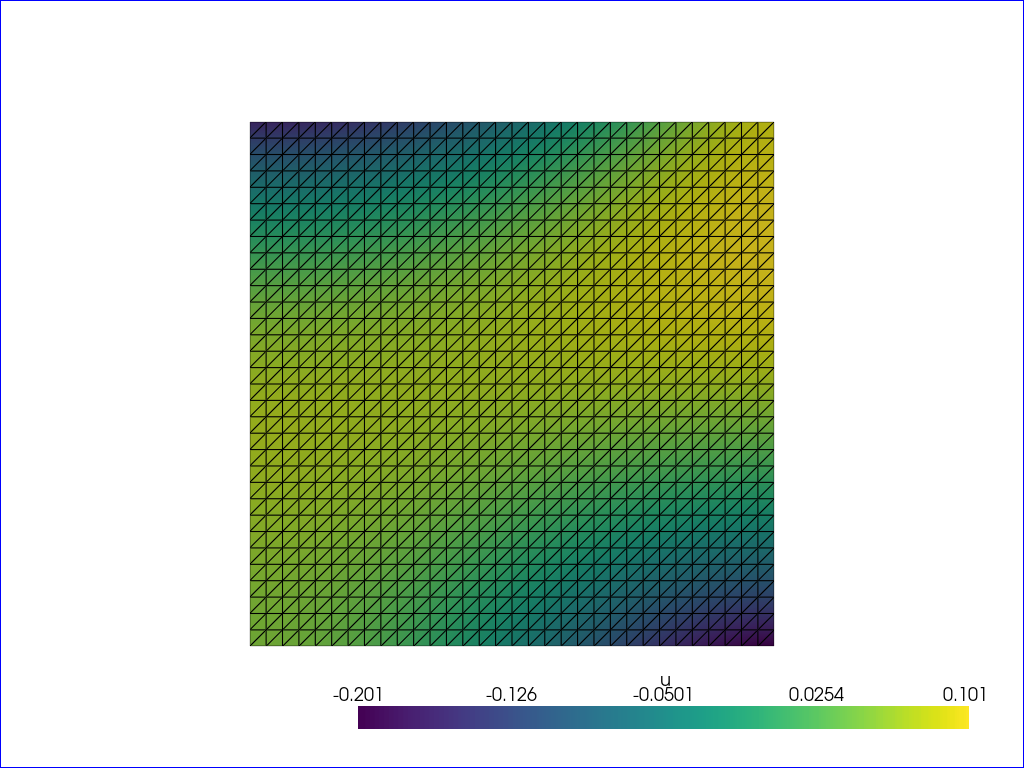

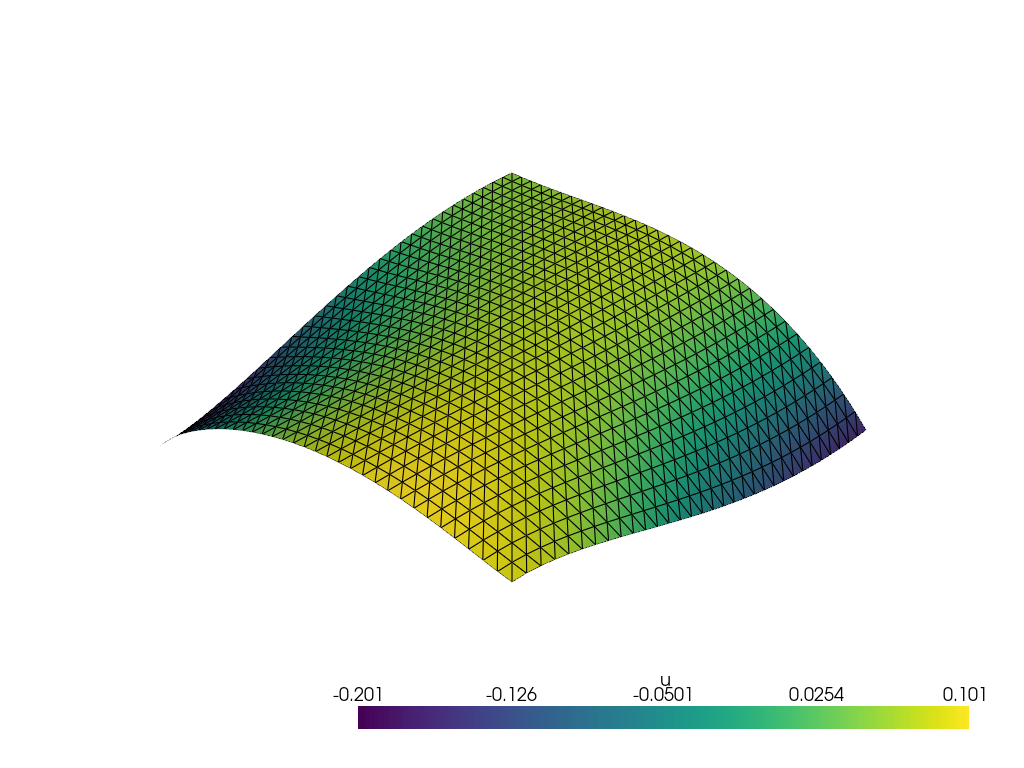

In [3]:
# Source term
f = 2 * r[1]

# Neumann conditions on the edge of the unit square
g = (n[1] * (r[1] ** 2 - r[0] ** 2))

# Writing L
L = f * v * ufl.dx - g * v * ufl.ds

# Solving the PDE
problem = LinearProblem(a,
                        L,
                        petsc_options = {"ksp_type": "preonly",
                                         "pc_type": "lu"})
uh = problem.solve()

# Plotting
u_topology, u_cell_types, u_geometry = dolfinx.plot.vtk_mesh(V)
u_grid = pv.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pv.Plotter(notebook = True,
                            border = True,
                            border_color = 'blue',
                            line_smoothing = True)
u_plotter.add_mesh(u_grid, show_edges = True)
u_plotter.view_xy()
u_plotter.show()

warped = u_grid.warp_by_scalar()
plotter2 = pv.Plotter()
plotter2.add_mesh(warped, show_edges=True, show_scalar_bar=True)
plotter2.show()